# Aim: 
To implement a mini transformer-based model and explore foundation models.

Task: Understand and implement key components of a Transformer decoder (GPT-style) including self-attention, multi-head attention, and positional embeddings.

· Implement scaled dot-product attention.

· Extend to multi-head attention.

· Add sinusoidal positional encodings.

· Build a mini decoder-only Transformer.

· Train on a toy dataset.

· Visualize attention maps.


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Layer
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [28]:
class MultiHeadAttention(Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)

        self.dense = Dense(d_model)
        self.attn_weights = None

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None, store_weights=False):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attn_weights = scaled_dot_product_attention(q, k, v, mask)
        if store_weights:
            self.attn_weights = attn_weights

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.num_heads * self.depth))
        output = self.dense(concat_attention)
        return output, attn_weights

In [29]:
def get_positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

In [30]:
class DecoderLayer(Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False, look_ahead_mask=None, store_weights=False):
        attn_output, _ = self.mha(x, x, x, mask=look_ahead_mask, store_weights=store_weights)
        out1 = self.layernorm1(x + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + self.dropout2(ffn_output, training=training))
        return out2

In [31]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, max_len, d_model, num_heads, dff, num_layers):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = get_positional_encoding(max_len, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.final_layer = Dense(vocab_size)
        self.max_len = max_len

    def call(self, x, training=False, store_weights=False):
        seq_len = tf.shape(x)[1]
        x = self.token_emb(x)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        look_ahead_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        look_ahead_mask = 1 - look_ahead_mask

        for dec_layer in self.dec_layers:
            x = dec_layer(x, training=training, look_ahead_mask=look_ahead_mask, store_weights=store_weights)

        logits = self.final_layer(x)
        return logits[:, -1, :]

In [32]:
sentences = [
    "hello world", "machine learning", "deep learning", "transformer is cool",
    "attention is all you need", "neural networks are powerful",
    "tensorflow and keras are great", "language models can generate text",
    "sequence to sequence learning", "deep models need data",
    "ai is changing the world", "smart models learn patterns",
    "python is widely used in ai", "transformers use self attention",
    "data drives machine learning"
]

tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1
reverse_tokenizer = {v: k for k, v in tokenizer.word_index.items()}
reverse_tokenizer[0] = '<PAD>'

SEQ_LEN = 12

def prepare_data(sentences, seq_len):
    inputs, targets = [], []
    for s in sentences:
        tokenized = tokenizer.texts_to_sequences([s])[0]
        for i in range(1, len(tokenized)):
            in_seq = tokenized[:i]
            out_seq = tokenized[i]
            in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=seq_len)[0]
            inputs.append(in_seq)
            targets.append(out_seq)
    return np.array(inputs), np.array(targets)

X, y = prepare_data(sentences, SEQ_LEN)

# =====================
# Model Setup
# =====================
model = Decoder(vocab_size, SEQ_LEN, d_model=64, num_heads=4, dff=128, num_layers=2)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print("Training the model...")
history = model.fit(X, y, epochs=50, batch_size=4)

Training the model...
Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.1197 - loss: 3.3222
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.1106 - loss: 2.8246
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1681 - loss: 2.8070
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1424 - loss: 2.8085
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1639 - loss: 2.7811
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1689 - loss: 2.7768
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1823 - loss: 2.7771
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1810 - loss: 2.7900
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1562 - loss: 2.7414
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1652 - loss: 2.7818
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1707 - loss: 2.7073
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)




SEQUENCE GENERATION WITH ATTENTION VISUALIZATION

Generating sequence starting with: 'transformers'
Generated sequence: 'transformers'' '
Visualizing attention for input: 'ransformers '


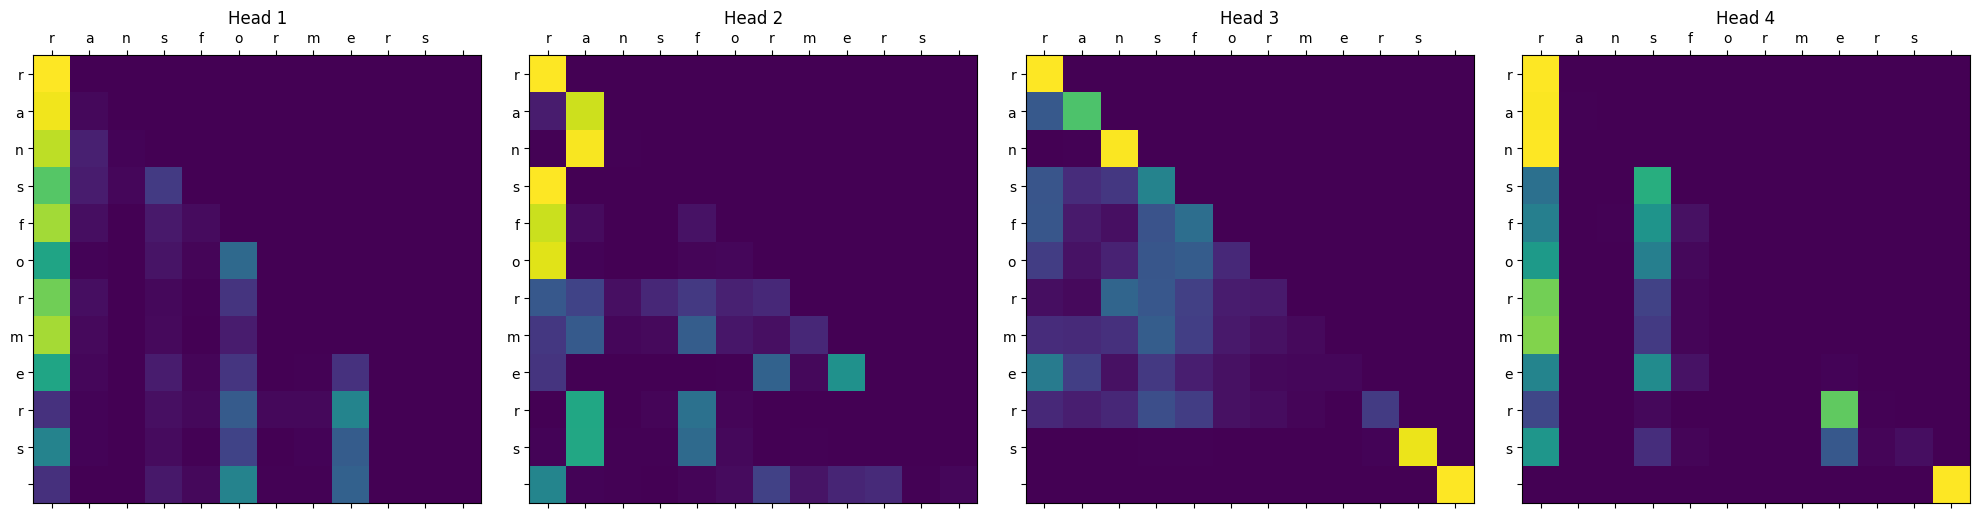

'u'
Visualizing attention for input: 'ansformers u'


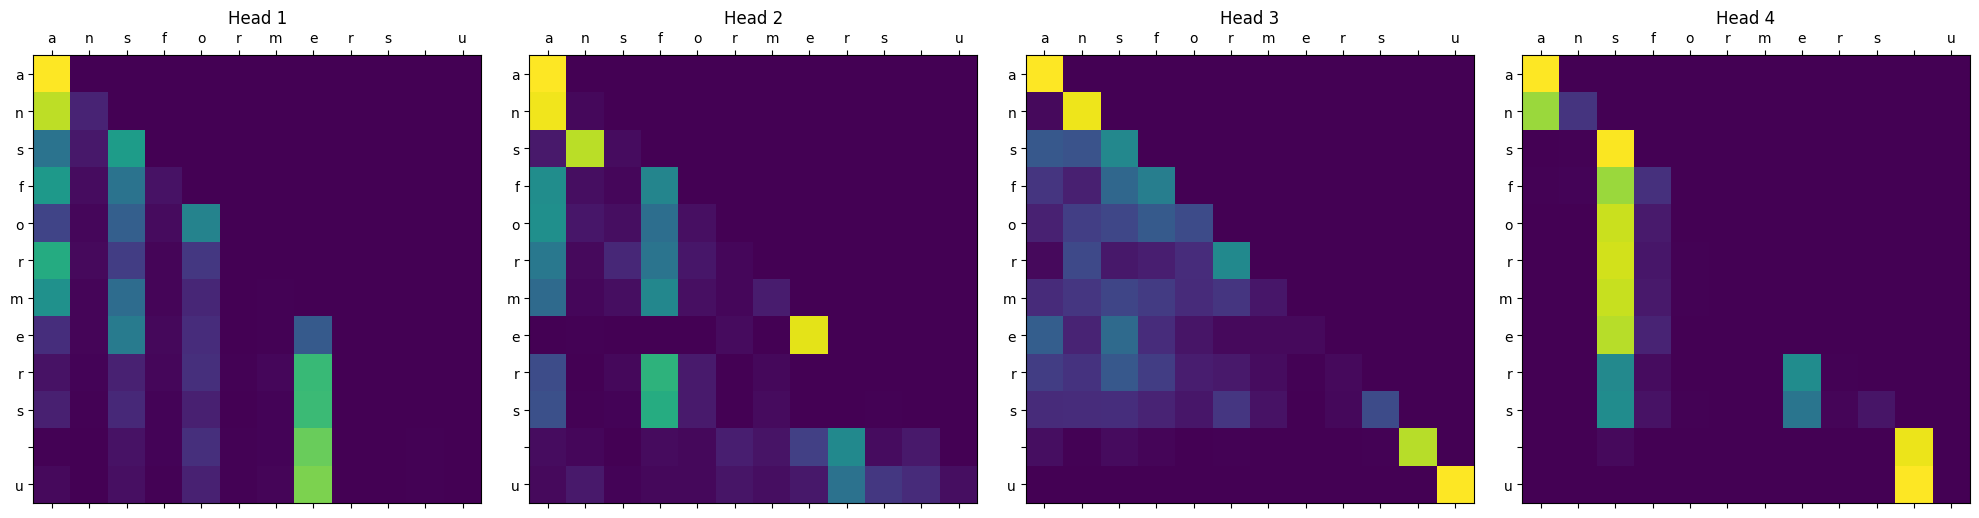

's'
Visualizing attention for input: 'nsformers us'


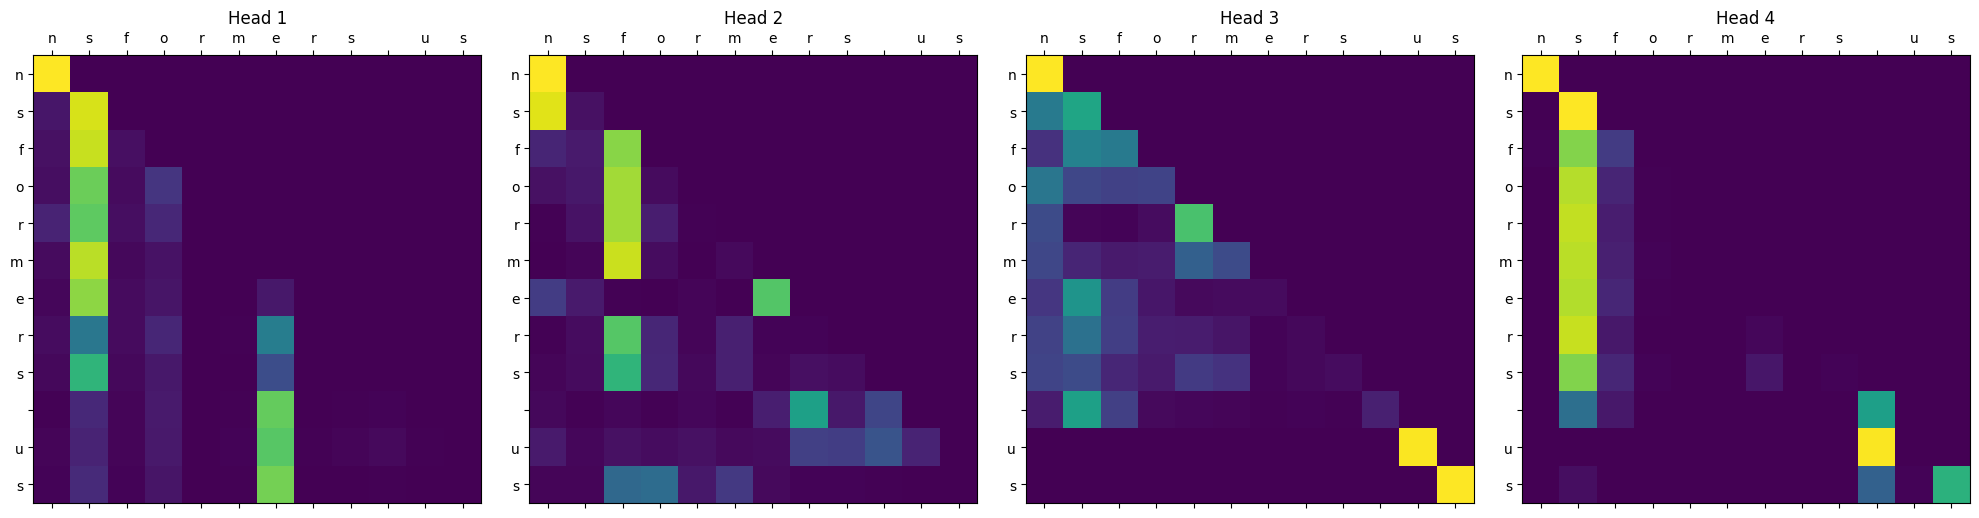

'e'
Visualizing attention for input: 'sformers use'


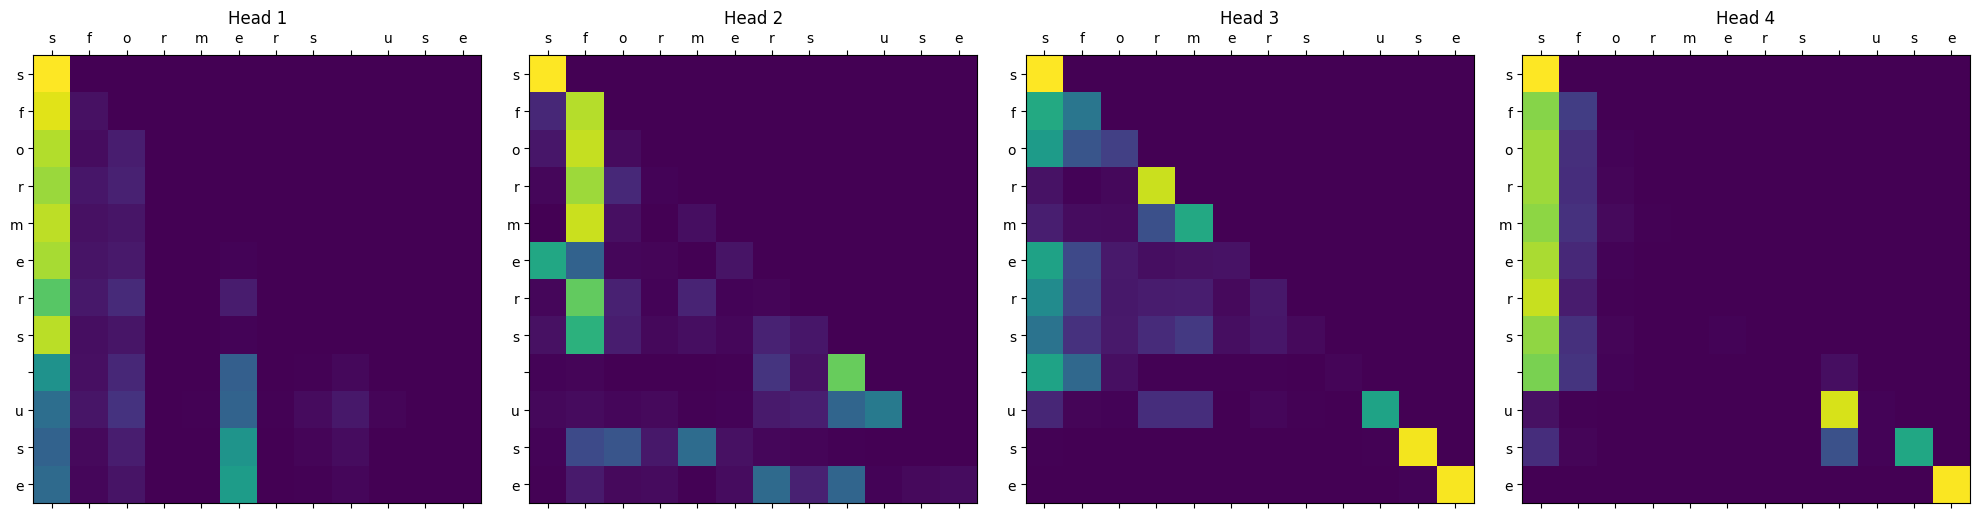

' '
Visualizing attention for input: 'formers use '


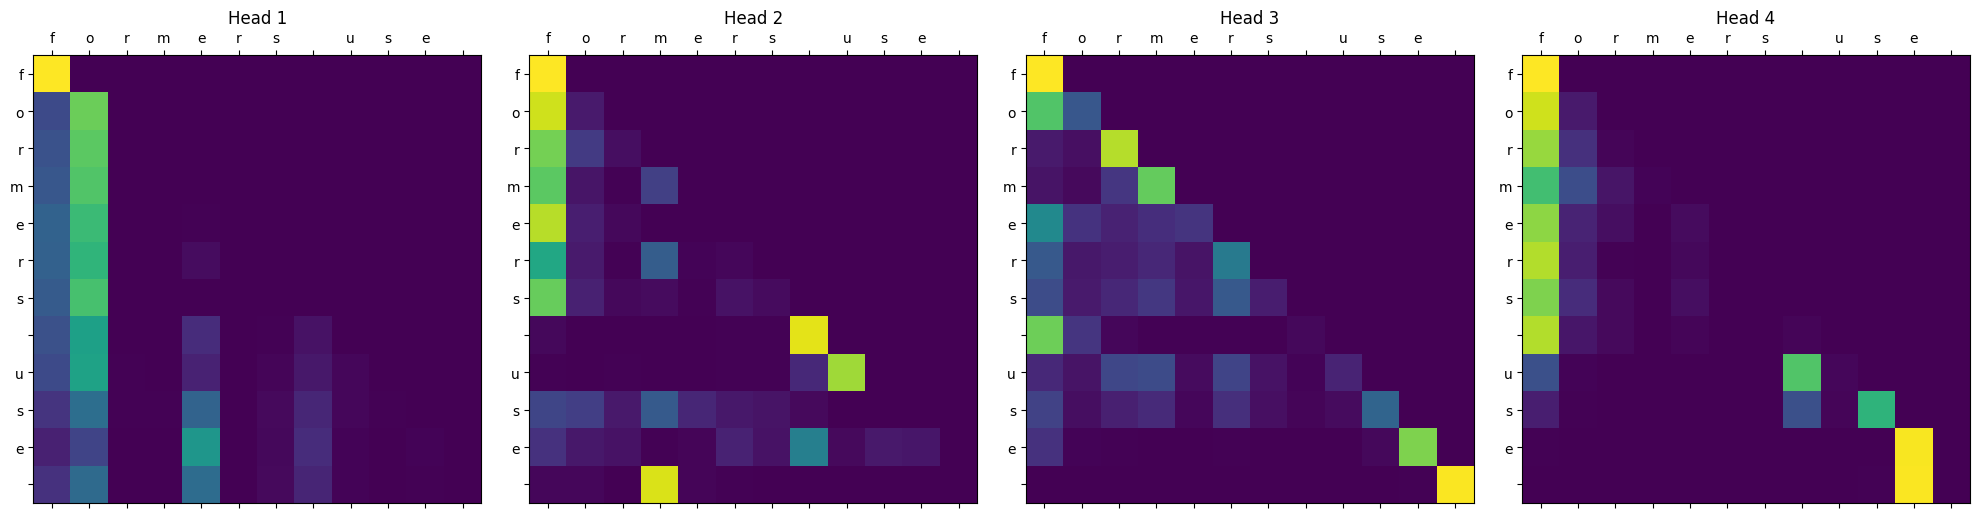

's'
Visualizing attention for input: 'ormers use s'


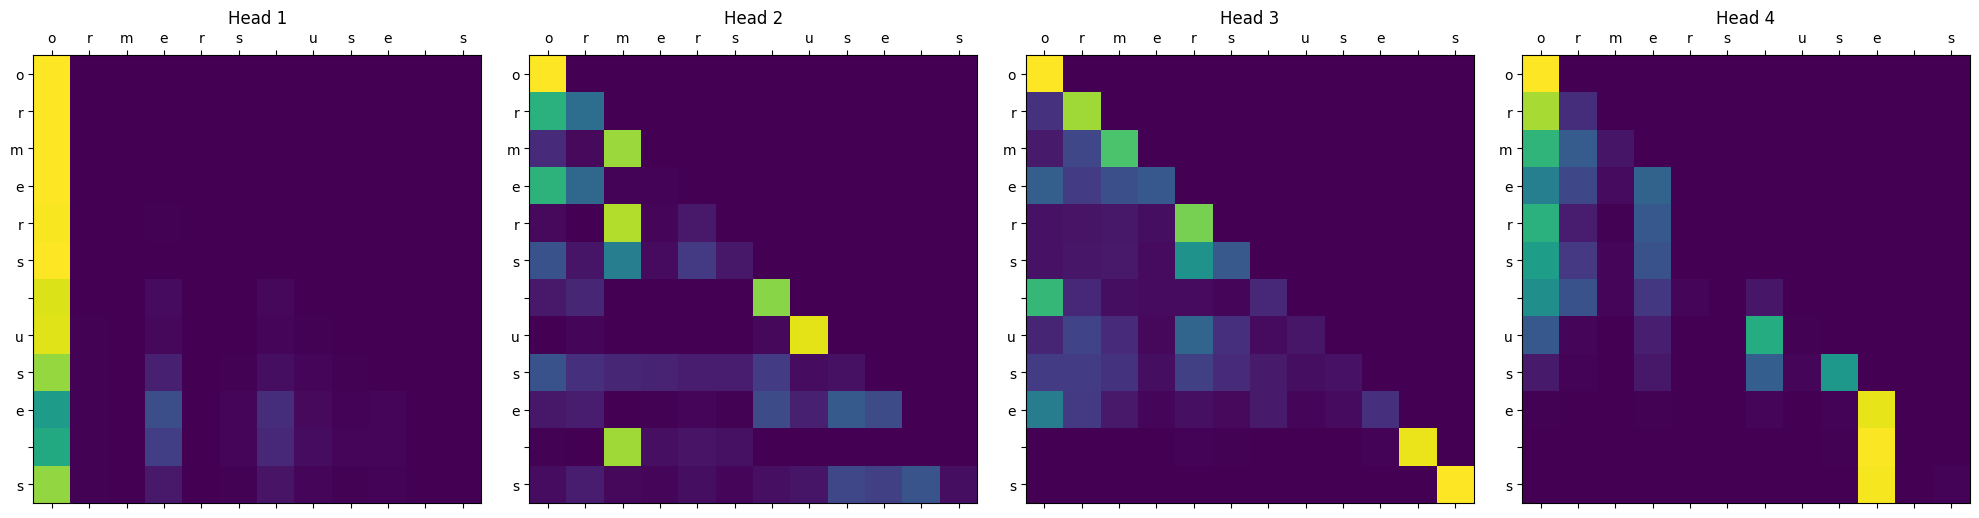

'e'
Visualizing attention for input: 'rmers use se'


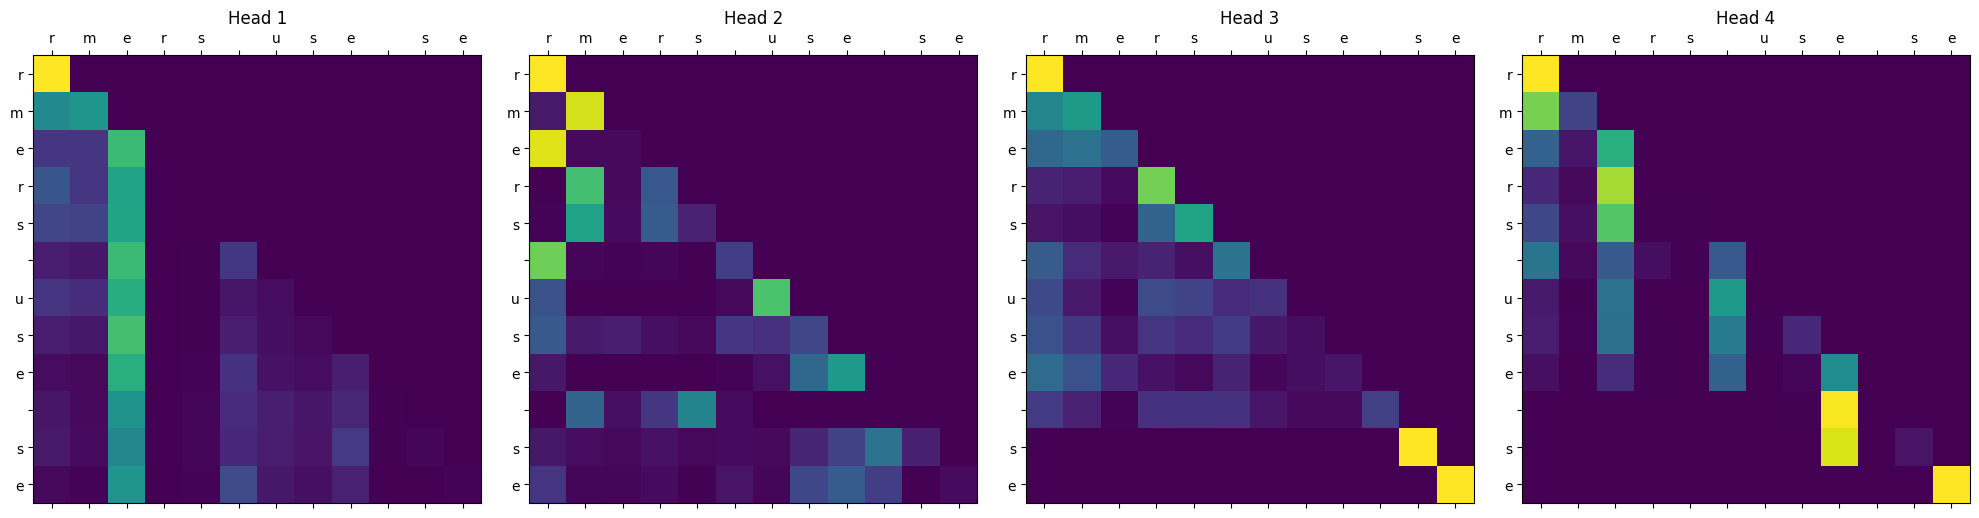

'l'
Visualizing attention for input: 'mers use sel'


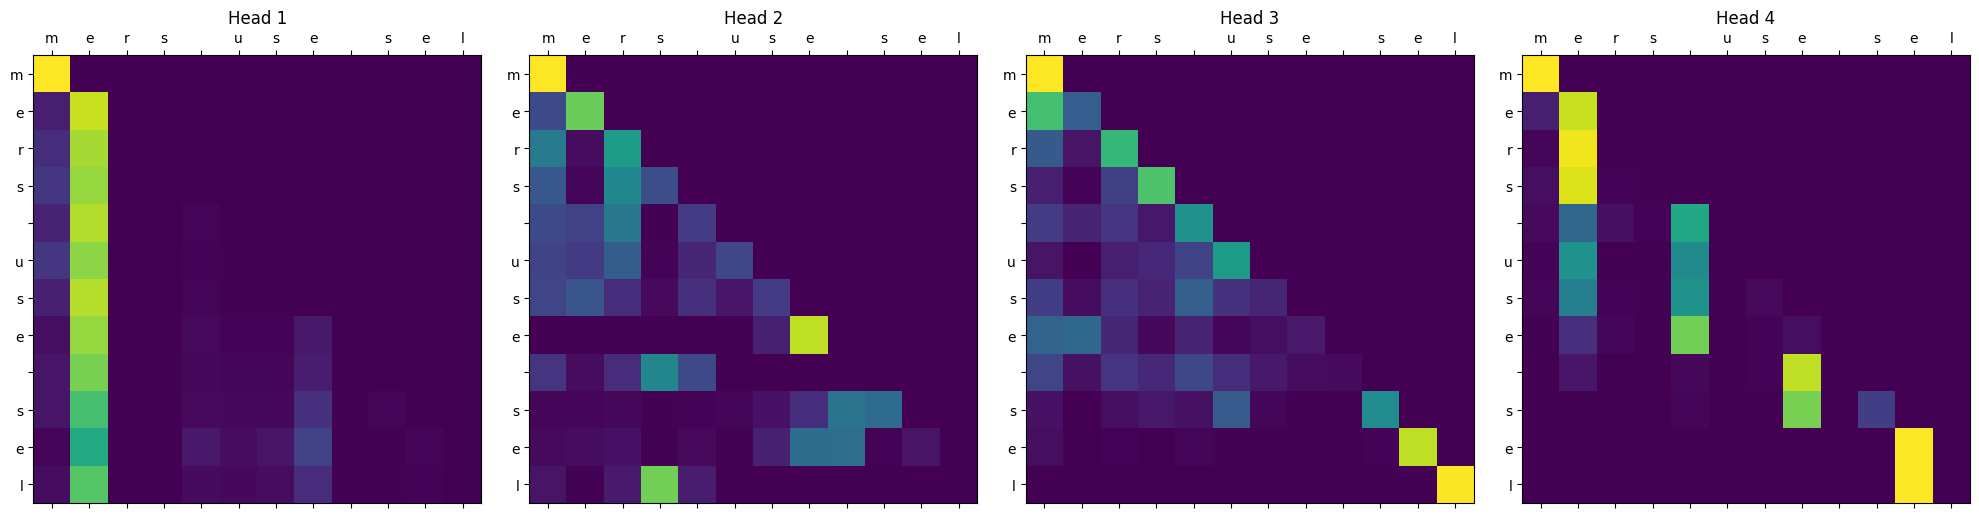

'f'
Visualizing attention for input: 'ers use self'


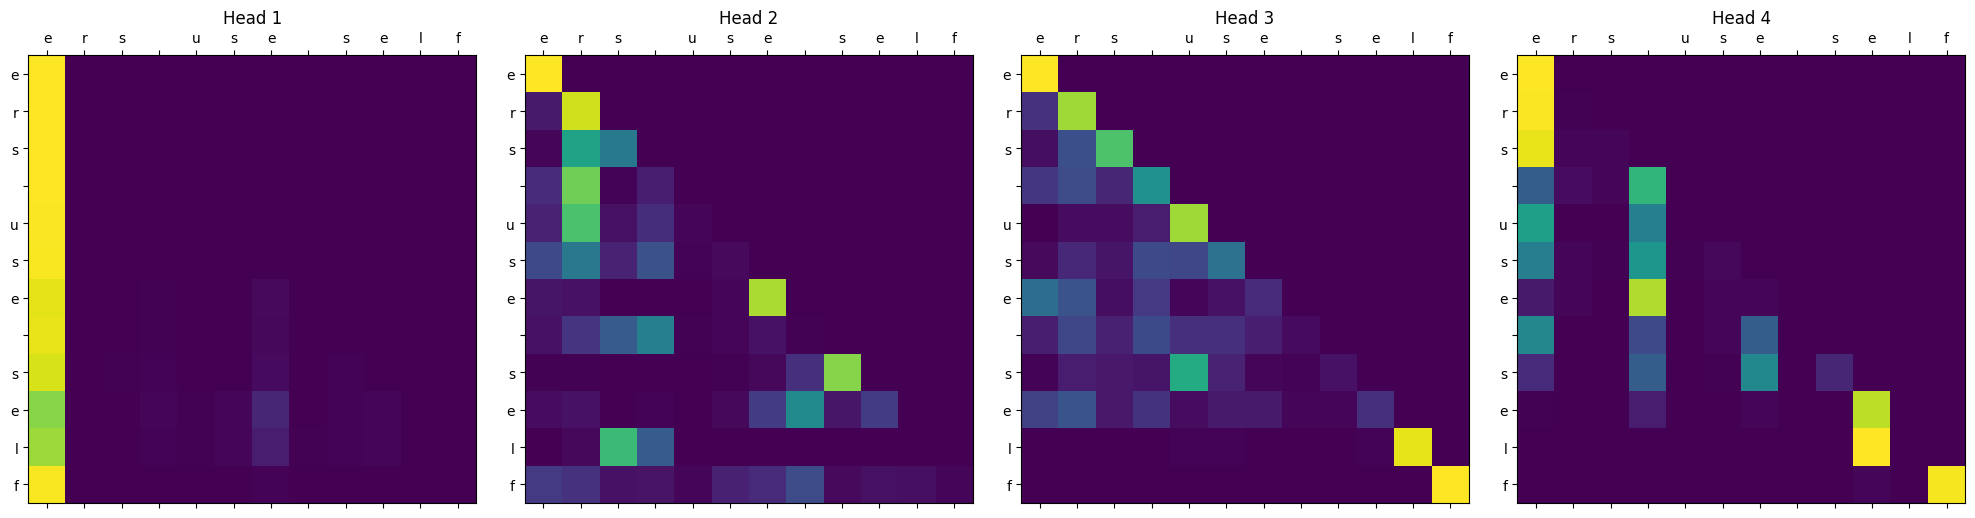

' '
Visualizing attention for input: 'rs use self '


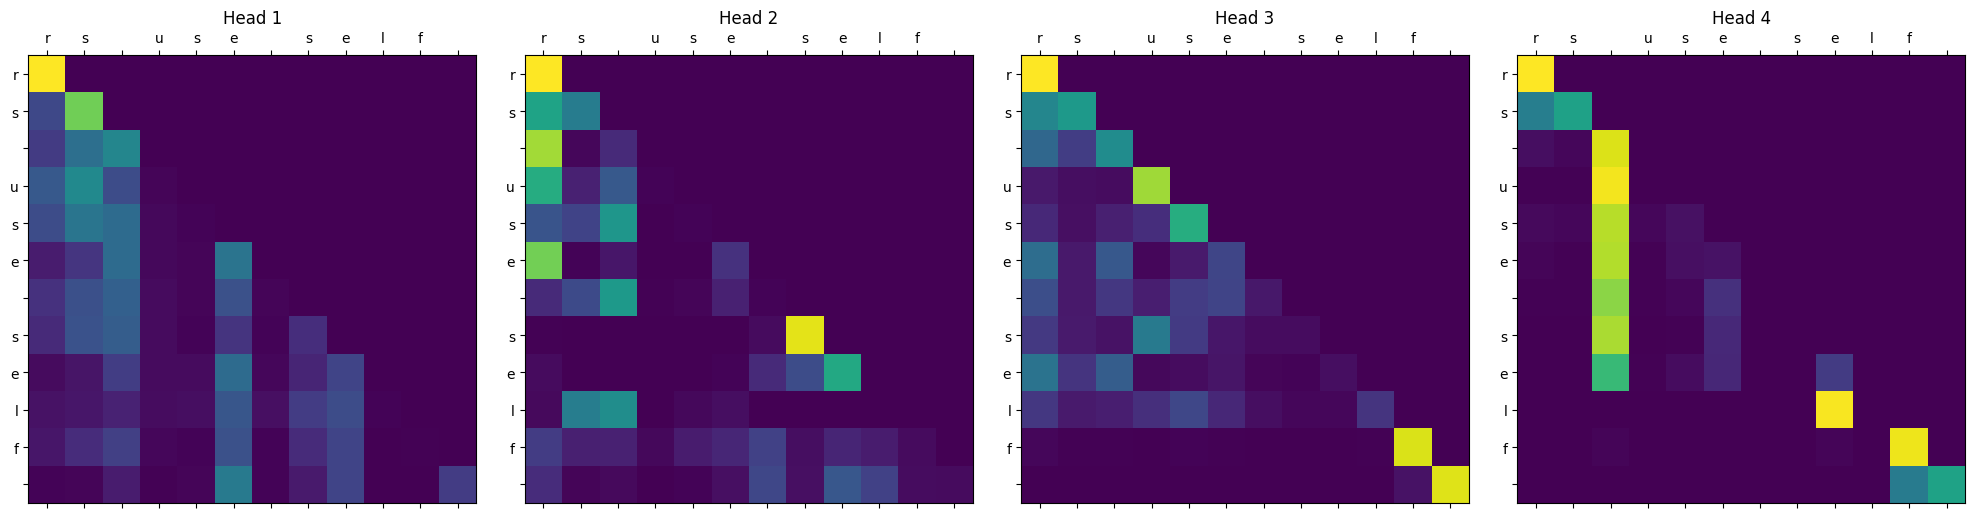


Final generated sequence: 'transformers use self '

Generating sequence starting with: 'neural'
Generated sequence: 'neural'' ''n''e''t''w''o''r''k''s'' '
Final generated sequence: 'neural networks '

Generating sequence starting with: 'machine'
Generated sequence: 'machine'' ''l''e''a''r''n''i''n''g'' '
Final generated sequence: 'machine learning '

Generating sequence starting with: 'self'
Generated sequence: 'self'' ''a''r''t''e''n''t''i''o''n'
Final generated sequence: 'self artention'


'self artention'

In [35]:
def predict_next_word(model, input_seq, tokenizer, reverse_tokenizer, seq_len):
    tokenized_input = tokenizer.texts_to_sequences([input_seq])[0]
    input_seq_padded = tf.keras.preprocessing.sequence.pad_sequences([tokenized_input], maxlen=seq_len)
    predictions = model(input_seq_padded, training=False, store_weights=True)
    predicted_token_id = tf.argmax(predictions[0]).numpy()
    predicted_char = reverse_tokenizer.get(predicted_token_id, '<UNK>')
    probabilities = tf.nn.softmax(predictions[0])
    confidence = tf.reduce_max(probabilities).numpy()
    return predicted_char, confidence, predicted_token_id, input_seq_padded

def plot_attention(model, input_sequence, tokenizer):
    mha_layer = model.dec_layers[0].mha
    attn_weights = mha_layer.attn_weights
    if attn_weights is None:
        print("Attention weights not found.")
        return

    attn_weights = attn_weights[0]
    input_tokens = list(input_sequence.rjust(SEQ_LEN))
    num_heads = attn_weights.shape[0]

    fig, axes = plt.subplots(1, num_heads, figsize=(20, 5))
    for i in range(num_heads):
        ax = axes[i]
        ax.matshow(attn_weights[i][:len(input_tokens), :len(input_tokens)], cmap='viridis')
        ax.set_title(f'Head {i+1}')
        ax.set_xticks(range(len(input_tokens)))
        ax.set_yticks(range(len(input_tokens)))
        ax.set_xticklabels(input_tokens)
        ax.set_yticklabels(input_tokens)
    plt.tight_layout()
    plt.show()

def generate_sequence(model, seed_text, num_chars=10, visualize=False):
    generated = seed_text
    current_input = seed_text
    print(f"\nGenerating sequence starting with: '{seed_text}'")
    print(f"Generated sequence: '{seed_text}'", end='')
    for _ in range(num_chars):
        predicted_char, confidence, _, input_seq_padded = predict_next_word(model, current_input, tokenizer, reverse_tokenizer, SEQ_LEN)
        generated += predicted_char
        current_input = current_input[-SEQ_LEN+1:] + predicted_char
        print(f"'{predicted_char}'", end='')

        if visualize:
            print(f"\nVisualizing attention for input: '{current_input}'")
            plot_attention(model, current_input, tokenizer)

    print(f"\nFinal generated sequence: '{generated}'")
    return generated


print("\n" + "="*60)
print("SEQUENCE GENERATION WITH ATTENTION VISUALIZATION")
print("="*60)

generate_sequence(model, "transformers", 10, visualize=True)
generate_sequence(model, "neural", 10, visualize=False )
generate_sequence(model, "machine", 10, visualize=False)
generate_sequence(model, "self", 10, visualize=False)

1. How the Architecture Works
Encoder-only
Mechanism: Uses only the encoder stack from Transformers.

Attention type: Bidirectional self-attention.

Processing: Considers the entire context.

Output: Dense vector representations for understanding input text.




Decoder-only
Mechanism: Uses only the decoder stack.

Attention type: Causal self-attention.

Processing: Predicts next token sequentially using previous tokens.

Output: Text generation (auto-regressive).





Encoder-Decoder (Seq2Seq)
Mechanism: Uses both encoder and decoder modules.

Attention type: Encoder = full attention; Decoder = masked + cross attention.

Processing: Encoder encodes input → decoder generates output based on encoder’s representation.

Output: Input-output pair tasks like translation.






2. Example Models
Encoder-only
BERT: Bidirectional context, pre-trained with MLM.

RoBERTa: BERT variant with larger data and no NSP.

ALBERT: Lightweight BERT variant (parameter sharing).

DeBERTa: Disentangled attention and better embeddings.




Decoder-only
GPT (1–4): Left-to-right generative models.

LLaMA: Efficient, open-weight GPT-style model.

PaLM: Pathways-based autoregressive model.

BLOOM: Open multilingual generative transformer.






Encoder-Decoder
T5: Text-to-text framework for multiple tasks.

BART: Denoising autoencoder for sequence tasks.

FLAN-T5: Instruction-tuned version of T5.

Pangu-α: Chinese foundation model using encoder-decoder.





3. Strengths, Weaknesses, Best Use Cases
Encoder-only
Strengths: Deep context understanding; efficient; great for classification.

Weaknesses: Not designed for text generation.

Best Use Cases: NLU tasks—sentiment analysis, classification, NER.





Decoder-only
Strengths: Excellent for generation; flexible with input length; strong few-shot/zero-shot.

Weaknesses: Limited full-context understanding; high compute demand.

Best Use Cases: Chatbots, code generation, creative writing.




Encoder-Decoder
Strengths: Balanced architecture; strong on conditional generation.

Weaknesses: Computationally intensive; larger memory footprint.

Best Use Cases: Translation, summarization, question answering.





4. Comparison/Ranking by Key Criteria
a. Versatility
Encoder-only: Limited to NLU.

Decoder-only: High; supports prompting, multi-tasking.

Encoder-Decoder: High; handles both NLU and NLG.

b. Performance on Low-resource Tasks
Encoder-only: Good with fine-tuning and PEFT methods.

Decoder-only: Strong with few-shot and zero-shot (no fine-tuning needed).

Encoder-Decoder: Less efficient without task-specific data.

c. Compute Efficiency
Encoder-only: Most efficient; smaller models, faster inference.

Decoder-only: Least efficient; sequential generation = slow & costly.

Encoder-Decoder: Moderate; dual-stack leads to higher resource use.